### An analysis on inspiral non-quadrupole detecton by combining GW190412 and GW190814

In [42]:
from __future__ import division

import lal
import lalsimulation as lalsim
import pycbc.frame
from pycbc.psd import welch, interpolate
from pycbc.filter import highpass_fir, resample_to_delta_t

import os
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
from mpmath import quad, inf, exp, pi
import h5py
import pycwt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15

import utils
uts = utils.MiscellaneousUtils()

### Load the data of $Y(\alpha)$ and $S_{lm}(\alpha)$

In [43]:
f1 = h5py.File("../GW190412/tmpData/YSalpha.h5py", "r")
E1_data = [ f1["Yalpha"][:], f1["Salpha22"][:], f1["Salpha33"][:], f1["Salpha44"][:], f1["Salpha21"][:] ]

f2 = h5py.File("../GW190814/tmpData/YSalpha.h5py", "r")
E2_data = [ f2["Yalpha"][:], f2["Salpha22"][:], f2["Salpha33"][:], f2["Salpha44"][:], f2["Salpha21"][:] ]

### We define three hypotheses for combining the multiple events

$ \mathcal{H}_1: S(\alpha) =  \sum_i a^{(i)}_{22}S^{(i)}_{22}(\alpha) $

$\mathcal{H}_2: S(\alpha) = \sum_i a^{(i)}_{22}S^{(i)}_{22}(\alpha) +  a^{(i)}_{33}S^{(i)}_{33}(\alpha)$

$\mathcal{H}_3: S(\alpha) = \sum_i a^{(i)}_{22}S^{(i)}_{22}(\alpha) +  a_{33}S^{(i)}_{33}(\alpha) + a_{44}S^{(i)}_{44}(\alpha)$

Maximize the LLR over the unknown paramters $a^{(i)}_{22}, a^{(i)}_{33}$, and $a^{(i)}_{44}$ as per the requirement.

### Load the off-source data and compute the combine covariance matrix

In [34]:
E1_NalphaDataFull = np.load("../GW190412/NoiseBG/NalphaData.npy")

# FIXME: Delete the Nalpha series whose first value is very high
# It occurs from the numrical error in time-frequency representation using CWT
idxx = np.where( E1_NalphaDataFull[:,0]>2500)[0]
E1_NalphaData = np.delete(E1_NalphaDataFull, idxx, axis=0)



E2_NalphaDataFull = np.load("../GW190814/NoiseBG/NalphaData.npy")

# FIXME: Delete the Nalpha series whose first value is very high
# It occurs from the numrical error in time-frequency representation using CWT
idxx = np.unique( np.hstack(( np.where( E2_NalphaDataFull[:,0]>2500)[0], \
                  np.where( np.max(E2_NalphaDataFull, axis=1)>6000)[0] )) )
E2_NalphaData = np.delete(E2_NalphaDataFull, idxx, axis=0)


min_length = min( len(E1_NalphaData), len(E2_NalphaData) )
CombNalphaData = E1_NalphaData[:min_length] + E2_NalphaData[:min_length] 

# Mean at each \alpha
mudata = np.mean(CombNalphaData, axis=0)
xy = np.vstack([CombNalphaData[:2000][:,j] - mudata[j] for j in range(len(mudata))])

# Covariance matrix
npcov = np.cov(xy)
covinv = np.linalg.inv(npcov)


In [35]:
def LogLikelihoodRatioGeneral(params, args):
    if min(params)<0:
        return 10000000
    else:
        sArr, yArr, covinv, mudata = args
        msArr = np.sum(np.array( [params[i]*sArr[i] for i in range(len(params))] ), axis=0)
        gammasq = np.dot( msArr, np.dot(covinv, msArr) )
        return - (np.dot( yArr-mudata, np.dot(covinv, msArr) )- 0.5 * gammasq)

In [36]:
Yalpha = E1_data[0]+E2_data[0]

initial_guess = [7.0, 4.0]
res22 = opt.minimize(LogLikelihoodRatioGeneral, initial_guess, args=[ [E1_data[1], E2_data[1] ], Yalpha, covinv, mudata],\
                   method='Powell', options={'ftol': 1e-20} )

initial_guess = [4.5, 2.5, 4.5, 2.5]
res22_33 = opt.minimize(LogLikelihoodRatioGeneral, initial_guess, args=[ \
                                [E1_data[1], E2_data[1], E1_data[2], E2_data[2]], \
                                Yalpha, covinv, mudata], method='Powell', options={'ftol': 1e-20} )

initial_guess = [4.5, 1.2, 2.3, 4.5, 1.2, 2.3]
res22_33_44 = opt.minimize(LogLikelihoodRatioGeneral, initial_guess, args=[ \
                            [E1_data[1], E2_data[1], E1_data[2], E2_data[2], E1_data[3], E2_data[3]]                                               , \
                            Yalpha, covinv, mudata], method='Powell', options={'ftol': 1e-20} )


In [37]:
print " LLR_H1: %s %s \n LLR_H2: %s % s\n LLR_H3: %s %s"%(-res22.fun, res22.x, -res22_33.fun, res22_33.x, -res22_33_44.fun, res22_33_44.x)

 LLR_H1: 2071.6353539653624 [ 7.2955455  75.93690132] 
 LLR_H2: 2153.363042077998 [  7.39047879  75.70647257  40.85345148 175.90339868]
 LLR_H3: 2155.1862917026456 [  7.38521001  75.69831655  41.76886653 175.99706733 105.49869102
  93.94099218]


In [47]:
sArr22_33 =   res22_33.x[0]*E1_data[1] + res22_33.x[1]*E2_data[1] \
            + res22_33.x[2]*E1_data[2] + res22_33.x[3]*E2_data[2]

gammasq22_33 = np.dot( sArr22_33, np.dot(covinv, sArr22_33) )

sArr22 = res22_33.x[0]*E1_data[1] + res22_33.x[1]*E2_data[1]
gammasq22 = np.dot( sArr22, np.dot(covinv, sArr22) )


Lambda22_33 = np.dot( Yalpha-mudata, np.dot(covinv, sArr22_33) )- 0.5 * gammasq22_33
Lambda22 = np.dot( Yalpha-mudata, np.dot(covinv, sArr22) ) - 0.5 * gammasq22
beta33 = (Lambda22_33 - Lambda22 + 0.5*gammasq22_33 - 0.5*gammasq22)/(gammasq22_33 - gammasq22)**0.5

print '\033[1m' + "\n", "Lambda22=%s, Lambda_22+33=%s, beta33=%s " % ( Lambda22, Lambda22_33, beta33)


sArr22_33_44 =    res22_33_44.x[0]*E1_data[1] + res22_33_44.x[1]*E2_data[1] \
                + res22_33_44.x[2]*E1_data[2] + res22_33_44.x[3]*E2_data[2] \
                + res22_33_44.x[4]*E1_data[3] + res22_33_44.x[5]*E2_data[3]

gammasq22_33_44 = np.dot(sArr22_33_44, np.dot(covinv, sArr22_33_44))
sArr22_33 = res22_33_44.x[0]*E1_data[1] + res22_33_44.x[1]*E2_data[1] \
                + res22_33_44.x[2]*E1_data[2] + res22_33_44.x[3]*E2_data[2]

gammasq22_33 = np.dot( sArr22_33, np.dot(covinv, sArr22_33) )
Lambda22_33_44 = np.dot( Yalpha-mudata, np.dot(covinv, sArr22_33_44) ) - 0.5 * gammasq22_33_44
beta44 = (Lambda22_33_44 + 0.5*gammasq22_33_44 - Lambda22_33 - 0.5*gammasq22_33)/(gammasq22_33_44 - gammasq22_33)**0.5

print "\n", '\033[1m' + "Lambda22_33_44=%s, beta44=%s"%(Lambda22_33_44, beta44)



Lambda22=2071.558164451163, Lambda_22+33=2153.363042077998, beta33=12.803730331681342 

Lambda22_33_44=2155.1862917026456, beta44=1.9309567231278582


## Calculate the probability distribution $p(\beta_{33} \mid \mathcal{H}_{0})$ using the off-source data

We use the pdf $p(\beta \mid \mathcal{H}_{0})$ to compute the FAP,

$\rm{FAP} = \int_{\beta_{33}}^{\infty} p(\beta \mid \mathcal{H}_{0}) d\beta$

In [39]:
idx2 = np.arange(2000, min_length)

sArr33 = res22_33.x[2]*E1_data[2] + res22_33.x[3]*E2_data[2]
gammasq33 = np.dot( sArr33, np.dot(covinv, sArr33) )

betaList = []
for ii in idx2:
    nArr = CombNalphaData[ii] - mudata
    lamb = np.dot( nArr, np.dot(covinv, sArr33) )/gammasq33**0.5
    betaList.append( lamb )
betaList = np.array(betaList)

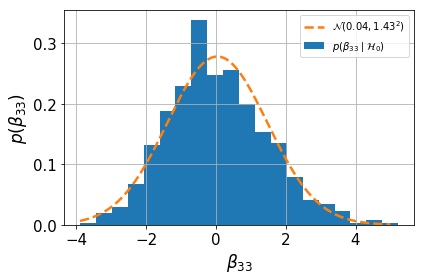

In [40]:
fig, ax = plt.subplots(figsize=(6, 4)) 
_ = ax.hist( betaList , density=True, bins=20 , label=r"$p(\beta_{33} \mid \mathcal{H}_{0})$")
ax.set_xlabel(r"$\beta_{33}$", fontsize=17)
ax.set_ylabel(r"$p(\beta_{33})$", fontsize=17)
#ax.set_xlim(-5.5, 5.5)
xArr = np.linspace(min(betaList), 5, 1000)
yArr = sts.norm.pdf(xArr, loc=np.mean(betaList), scale=np.std(betaList))
ax.plot(xArr, yArr, ls='--', label=r"$\mathcal{N}(%.2f, %.2f^{2})$"%(np.mean(betaList),   np.std(betaList)), lw=2.5)
ax.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("tmpData/betaDist33.png", dpi=150)

In [41]:
sigma = np.std(betaList)
mu = np.mean(betaList)
beta = beta33
print '\033[1m' + "gamma33=", gammasq33**0.5, "beta33 =", beta33, ", FAP =", \
            quad(lambda x: (1.0/(2.0*np.pi*sigma**2)**0.5)*exp(-(x-mu)**2/(2.0*sigma**2.0)), [beta, np.inf])

gamma33= 12.796637786235381 beta33 = 12.803730331681342 , FAP = 2.67817517273541e-19
